
CPU Execution Time: 1315.76610 milliseconds
Memory Usage (CPU): 762.94 MB

GPU Execution Time: 537.02116 milliseconds
Memory Usage (GPU): 762.94 MB
The interior elements match within the specified threshold of 4.81248665557452. Match: True for cuda


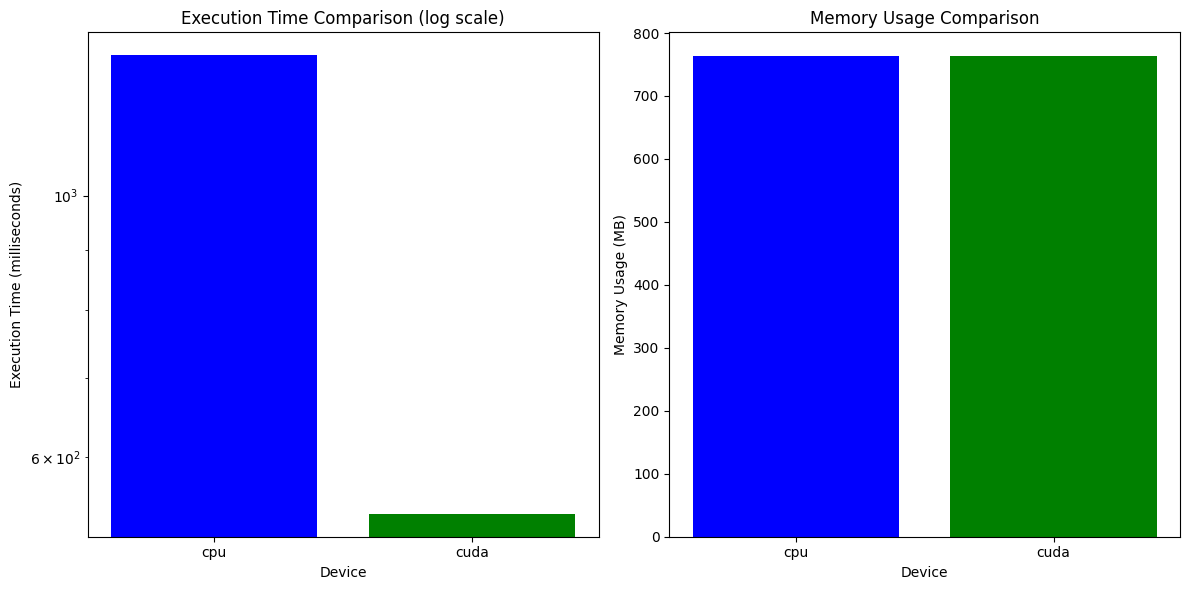

The GPU is approximately 2.45 times faster than the CPU in terms of execution time.


In [1]:
import time
import numpy as np
import cProfile
import pandas as pd
import matplotlib.pyplot as plt
from numba import stencil, cuda, njit

@stencil
def laplacian_2d_stencil(a):
    return -4 * a[0, 0] + a[-1, 0] + a[1, 0] + a[0, -1] + a[0, 1]

# Define a CPU version of the Laplacian stencil using Numba's njit decorator
@njit
def laplacian_2d_cpu(a):
    result = np.empty_like(a)
    for i in range(1, a.shape[0] - 1):
        for j in range(1, a.shape[1] - 1):
            result[i, j] = -4 * a[i, j] + a[i - 1, j] + a[i + 1, j] + a[i, j - 1] + a[i, j + 1]
    return result

@cuda.jit
def laplacian_2d_kernel(d_a):
    i, j = cuda.grid(2)
    
    if 1 <= i < d_a.shape[0] - 1 and 1 <= j < d_a.shape[1] - 1:
        laplacian_sum = -4 * d_a[i, j]
        laplacian_sum += d_a[i - 1, j] + d_a[i + 1, j] + d_a[i, j - 1] + d_a[i, j + 1]
        d_a[i, j] = laplacian_sum

def measure_memory_usage(obj):
    return obj.nbytes / (1024 ** 2)  # Convert bytes to megabytes
# ... (previous code)

# Create a random array
array_size = 10000
a = np.random.rand(array_size, array_size)

# Specify devices for comparison
devices = ['cpu', 'cuda']

# List to store results
results_list = []
d_a = None  # Define d_a outside the if block
for device in devices:
    if device == 'cpu':
        # Run on CPU
        with cProfile.Profile() as pr_cpu:
            start_time_cpu = time.time()
            result_cpu = laplacian_2d_cpu(a)
            end_time_cpu = time.time()
            execution_time_cpu = (end_time_cpu - start_time_cpu) * 1e3  # Convert to microseconds

        # Memory usage on CPU
        memory_usage_cpu = measure_memory_usage(result_cpu)
        
        print(f"\nCPU Execution Time: {execution_time_cpu:.5f} milliseconds")
        print(f"Memory Usage (CPU): {memory_usage_cpu:.2f} MB")
        
        results_list.append({'Device': device, 'Execution Time': execution_time_cpu, 'Memory Usage': memory_usage_cpu})

    elif device == 'cuda':
        # Run on GPU
        d_a = cuda.to_device(a)
        
        with cProfile.Profile() as pr_gpu:
            threads_per_block = (16, 16)
            blocks_per_grid = ((a.shape[0] - 1) // threads_per_block[0] + 1, (a.shape[1] - 1) // threads_per_block[1] + 1)
            
            start_time_gpu = time.time()
            laplacian_2d_kernel[blocks_per_grid, threads_per_block](d_a)
            end_time_gpu = time.time()
            execution_time_gpu = (end_time_gpu - start_time_gpu) * 1e3  # Convert to microseconds
        
        # Display GPU profiling results
        print(f"\nGPU Execution Time: {execution_time_gpu:.5f} milliseconds")
        
        # Memory usage on GPU
        memory_usage_gpu = measure_memory_usage(d_a.copy_to_host())
        print(f"Memory Usage (GPU): {memory_usage_gpu:.2f} MB")
        
        results_list.append({'Device': device, 'Execution Time': execution_time_gpu, 'Memory Usage': memory_usage_gpu})

# Compare results between CPU and GPU
interior_cpu = laplacian_2d_cpu(a)[1:-1, 1:-1]
interior_gpu = d_a.copy_to_host()[1:-1, 1:-1]

# Ensure the shapes match for comparison
min_shape = min(interior_cpu.shape[0], interior_gpu.shape[0])
interior_cpu = interior_cpu[:min_shape, :min_shape]
interior_gpu = interior_gpu[:min_shape, :min_shape]

threshold = np.max(np.abs(interior_cpu - interior_gpu))
match = np.allclose(interior_cpu, interior_gpu, atol=threshold)

print(f"The interior elements match within the specified threshold of {threshold}. Match: {match} for {device}")

# Create DataFrame from the list
results_df = pd.DataFrame(results_list)
# ... (previous code)

# Plot the results using a bar chart with a logarithmic scale
plt.figure(figsize=(12, 6))

# Bar chart for Execution Time with logarithmic scale
plt.subplot(1, 2, 1)
plt.bar(results_df['Device'], results_df['Execution Time'], color=['blue', 'green'])
plt.yscale('log')  # Set logarithmic scale
plt.title('Execution Time Comparison (log scale)')
plt.xlabel('Device')
plt.ylabel('Execution Time (milliseconds)')

# Bar chart for Memory Usage
plt.subplot(1, 2, 2)
plt.bar(results_df['Device'], results_df['Memory Usage'], color=['blue', 'green'])
plt.title('Memory Usage Comparison')
plt.xlabel('Device')
plt.ylabel('Memory Usage (MB)')

plt.tight_layout()
plt.show()


# Calculate speedup factor
cpu_execution_time = results_df.loc[results_df['Device'] == 'cpu', 'Execution Time'].values[0]
gpu_execution_time = results_df.loc[results_df['Device'] == 'cuda', 'Execution Time'].values[0]

if gpu_execution_time > 0:
    speedup_factor = cpu_execution_time / gpu_execution_time
    print(f"The GPU is approximately {speedup_factor:.2f} times faster than the CPU in terms of execution time.")
else:
    print("The GPU execution time is very close to zero. Considerable speedup factor not defined.")
